In [1]:
from __future__ import print_function

import os, sys
import numpy as np
import warnings

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
# Transform
BatchSize = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3801,))
])

In [4]:
# Data
# trainSet = datasets.MNIST(root='data', download=True, train=True, transform=transform)
# testSet  = datasets.MNIST(root='data', download=True, train=False, transform=transform)

# trainLoader = dset.DataLoader(trainSet, batch_size=BatchSize, shuffle=True)
# testLoader = dset.DataLoader(testSet, batch_size=BatchSize, shuffle=False)

In [5]:
class myMnistDataset(Dataset):
    
    csvPath = 'D:\\GitWork\\mnist\\csvFiles\\'
    training_file = 'mnist_train.csv'
    test_file = 'mnist_test.csv'
    
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
    
    def __init__(self, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        data = np.loadtxt(os.path.join(self.csvPath, data_file), delimiter=',', dtype=np.float32)
        
        self.len = data.shape[0]
        imgs = torch.from_numpy(data[:, 1:])
        self.images = imgs.type(torch.uint8).view(self.len, 28, 28)
        
        lbls = torch.from_numpy(data[:, [0]])
        self.labels = lbls.view(self.len)

    def __getitem__(self, index):
        img, lbl = self.images[index], int(self.labels[index])
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            lbl = self.target_transform(lbl)
            
        return img, lbl

    def __len__(self):
        return self.len
    
    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed labels")
        return self.labels

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed labels")
        return self.labels

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed images")
        return self.images

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed images")
        return self.images
    
    
# Create datasets
trainSet = myMnistDataset(train=True, transform=transform)
testSet = myMnistDataset(train=False, transform=transform)

trainLoader = DataLoader(dataset=trainSet, batch_size=BatchSize, shuffle=True)
testLoader = DataLoader(dataset=testSet, batch_size=BatchSize, shuffle=False)   

In [6]:
print(trainSet.train_data.size())
print(trainSet.train_labels.size())

print(type(trainSet.train_data[0]))
print(type(trainSet.train_labels[0]))

print(trainSet.train_data[0])
print(trainSet.train_labels[0])

torch.Size([60000, 28, 28])
torch.Size([60000])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175

C:\opt\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:58: UserWarning: train_data has been renamed images
C:\opt\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:48: UserWarning: train_labels has been renamed labels


C:\opt\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:58: UserWarning: train_data has been renamed images
C:\opt\miniconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:48: UserWarning: train_labels has been renamed labels


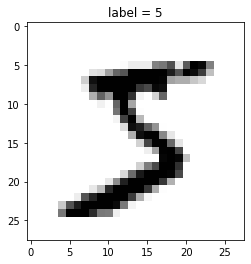

In [7]:
import matplotlib.pyplot as plt

plt.imshow(trainSet.train_data[0].numpy(), cmap='binary')
plt.title('label = %i' % trainSet.train_labels[0])
plt.show()

In [8]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)


net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


In [9]:
# Parameters
epochs = 3
lr = 0.002
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

In [10]:
# Train
for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Foward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % BatchSize == 0 or i+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, i+1, len(trainLoader), running_loss/2000))

print('Training Finished.')

[1/3, 100/600] loss: 0.108
[1/3, 200/600] loss: 0.172
[1/3, 300/600] loss: 0.205
[1/3, 400/600] loss: 0.229
[1/3, 500/600] loss: 0.249
[1/3, 600/600] loss: 0.268
[2/3, 100/600] loss: 0.018
[2/3, 200/600] loss: 0.035
[2/3, 300/600] loss: 0.051
[2/3, 400/600] loss: 0.066
[2/3, 500/600] loss: 0.081
[2/3, 600/600] loss: 0.094
[3/3, 100/600] loss: 0.014
[3/3, 200/600] loss: 0.027
[3/3, 300/600] loss: 0.039
[3/3, 400/600] loss: 0.052
[3/3, 500/600] loss: 0.065
[3/3, 600/600] loss: 0.077
Training Finished.


In [11]:
# Test
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
    for data in testLoader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            print(class_correct)
            print(class_total)

for i in range(10):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 93 %
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 3]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 3]
[2, 2, 1, 0, 3,

[12, 19, 13, 12, 16, 7, 12, 11, 9, 17]
[12, 19, 13, 15, 18, 9, 12, 12, 13, 18]
[12, 19, 13, 12, 16, 7, 12, 12, 9, 17]
[12, 19, 13, 15, 18, 9, 12, 13, 13, 18]
[12, 19, 14, 12, 16, 7, 12, 12, 9, 17]
[12, 19, 14, 15, 18, 9, 12, 13, 13, 18]
[12, 20, 14, 12, 16, 7, 12, 12, 9, 17]
[12, 20, 14, 15, 18, 9, 12, 13, 13, 18]
[13, 20, 14, 12, 16, 7, 12, 12, 9, 17]
[13, 20, 14, 15, 18, 9, 12, 13, 13, 18]
[13, 20, 14, 12, 16, 8, 12, 12, 9, 17]
[13, 20, 14, 15, 18, 10, 12, 13, 13, 18]
[13, 20, 14, 12, 16, 9, 12, 12, 9, 17]
[13, 20, 14, 15, 18, 11, 12, 13, 13, 18]
[13, 20, 15, 12, 16, 9, 12, 12, 9, 17]
[13, 20, 15, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 15, 12, 16, 9, 12, 12, 9, 17]
[14, 20, 15, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 16, 12, 16, 9, 12, 12, 9, 17]
[14, 20, 16, 15, 18, 11, 12, 13, 13, 18]
[14, 20, 16, 12, 16, 9, 12, 12, 9, 17]
[14, 20, 16, 15, 18, 11, 12, 14, 13, 18]
[14, 20, 16, 12, 16, 9, 12, 12, 9, 18]
[14, 20, 16, 15, 18, 11, 12, 14, 13, 19]
[14, 20, 16, 12, 16, 9, 12, 12, 10, 18]
[14, 

[28, 32, 26, 27, 37, 19, 23, 29, 21, 24]
[28, 32, 27, 35, 39, 21, 24, 32, 25, 28]
[28, 32, 26, 27, 38, 19, 23, 29, 21, 24]
[28, 32, 27, 35, 40, 21, 24, 32, 25, 28]
[28, 33, 26, 27, 38, 19, 23, 29, 21, 24]
[28, 33, 27, 35, 40, 21, 24, 32, 25, 28]
[28, 33, 26, 27, 38, 20, 23, 29, 21, 24]
[28, 33, 27, 35, 40, 22, 24, 32, 25, 28]
[28, 33, 27, 27, 38, 20, 23, 29, 21, 24]
[28, 33, 28, 35, 40, 22, 24, 32, 25, 28]
[28, 33, 27, 27, 38, 20, 23, 29, 22, 24]
[28, 33, 28, 35, 40, 22, 24, 32, 26, 28]
[28, 33, 27, 27, 38, 20, 23, 29, 22, 24]
[28, 33, 28, 36, 40, 22, 24, 32, 26, 28]
[28, 33, 27, 27, 39, 20, 23, 29, 22, 24]
[28, 33, 28, 36, 41, 22, 24, 32, 26, 28]
[28, 33, 27, 27, 39, 20, 23, 29, 22, 25]
[28, 33, 28, 36, 41, 22, 24, 32, 26, 29]
[28, 33, 27, 27, 39, 21, 23, 29, 22, 25]
[28, 33, 28, 36, 41, 23, 24, 32, 26, 29]
[28, 33, 27, 27, 39, 21, 24, 29, 22, 25]
[28, 33, 28, 36, 41, 23, 25, 32, 26, 29]
[28, 33, 27, 27, 39, 21, 24, 29, 22, 26]
[28, 33, 28, 36, 41, 23, 25, 32, 26, 30]
[28, 33, 27, 27,

[39, 47, 46, 36, 44, 32, 39, 46, 36, 38]
[39, 49, 47, 47, 46, 37, 41, 52, 41, 45]
[40, 47, 46, 36, 44, 32, 39, 46, 36, 38]
[40, 49, 47, 47, 46, 37, 41, 52, 41, 45]
[40, 47, 46, 36, 44, 32, 39, 46, 36, 38]
[40, 49, 47, 47, 46, 37, 41, 52, 41, 46]
[40, 47, 46, 37, 44, 32, 39, 46, 36, 38]
[40, 49, 47, 48, 46, 37, 41, 52, 41, 46]
[40, 47, 46, 37, 44, 32, 39, 46, 36, 39]
[40, 49, 47, 48, 46, 37, 41, 52, 41, 47]
[40, 47, 46, 37, 44, 32, 39, 46, 36, 40]
[40, 49, 47, 48, 46, 37, 41, 52, 41, 48]
[40, 48, 46, 37, 44, 32, 39, 46, 36, 40]
[40, 50, 47, 48, 46, 37, 41, 52, 41, 48]
[40, 48, 46, 37, 44, 32, 39, 46, 36, 40]
[40, 50, 47, 48, 46, 37, 41, 52, 41, 49]
[40, 48, 46, 38, 44, 32, 39, 46, 36, 40]
[40, 50, 47, 49, 46, 37, 41, 52, 41, 49]
[40, 48, 46, 38, 44, 32, 39, 46, 36, 41]
[40, 50, 47, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 47, 38, 44, 32, 39, 46, 36, 41]
[40, 50, 48, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 48, 38, 44, 32, 39, 46, 36, 41]
[40, 50, 49, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 48, 38,

[53, 64, 60, 56, 58, 43, 52, 54, 49, 56]
[53, 66, 61, 68, 60, 48, 54, 61, 57, 68]
[53, 64, 60, 56, 58, 43, 52, 55, 49, 56]
[53, 66, 61, 68, 60, 48, 54, 62, 57, 68]
[53, 64, 61, 56, 58, 43, 52, 55, 49, 56]
[53, 66, 62, 68, 60, 48, 54, 62, 57, 68]
[53, 64, 61, 56, 58, 43, 52, 55, 49, 57]
[53, 66, 62, 68, 60, 48, 54, 62, 57, 69]
[53, 64, 61, 56, 58, 43, 53, 55, 49, 57]
[53, 66, 62, 68, 60, 48, 55, 62, 57, 69]
[53, 64, 61, 56, 58, 43, 53, 55, 49, 58]
[53, 66, 62, 68, 60, 48, 55, 62, 57, 70]
[53, 64, 61, 56, 58, 43, 53, 55, 50, 58]
[53, 66, 62, 68, 60, 48, 55, 62, 58, 70]
[53, 64, 61, 56, 58, 43, 54, 55, 50, 58]
[53, 66, 62, 68, 60, 48, 56, 62, 58, 70]
[54, 64, 61, 56, 58, 43, 54, 55, 50, 58]
[54, 66, 62, 68, 60, 48, 56, 62, 58, 70]
[54, 64, 61, 56, 58, 43, 54, 55, 51, 58]
[54, 66, 62, 68, 60, 48, 56, 62, 59, 70]
[54, 65, 61, 56, 58, 43, 54, 55, 51, 58]
[54, 67, 62, 68, 60, 48, 56, 62, 59, 70]
[54, 65, 61, 56, 58, 43, 54, 56, 51, 58]
[54, 67, 62, 68, 60, 48, 56, 63, 59, 70]
[54, 65, 61, 56,

[61, 84, 76, 71, 73, 55, 69, 69, 65, 71]
[62, 86, 78, 84, 75, 61, 71, 76, 74, 85]
[61, 84, 76, 71, 73, 55, 69, 69, 66, 71]
[62, 86, 78, 84, 75, 61, 71, 76, 75, 85]
[61, 84, 76, 71, 73, 55, 70, 69, 66, 71]
[62, 86, 78, 84, 75, 61, 72, 76, 75, 85]
[61, 84, 76, 71, 73, 55, 70, 70, 66, 71]
[62, 86, 78, 84, 75, 61, 72, 77, 75, 85]
[62, 84, 76, 71, 73, 55, 70, 70, 66, 71]
[63, 86, 78, 84, 75, 61, 72, 77, 75, 85]
[63, 84, 76, 71, 73, 55, 70, 70, 66, 71]
[64, 86, 78, 84, 75, 61, 72, 77, 75, 85]
[63, 85, 76, 71, 73, 55, 70, 70, 66, 71]
[64, 87, 78, 84, 75, 61, 72, 77, 75, 85]
[63, 85, 77, 71, 73, 55, 70, 70, 66, 71]
[64, 87, 79, 84, 75, 61, 72, 77, 75, 85]
[63, 85, 77, 72, 73, 55, 70, 70, 66, 71]
[64, 87, 79, 85, 75, 61, 72, 77, 75, 85]
[63, 86, 77, 72, 73, 55, 70, 70, 66, 71]
[64, 88, 79, 85, 75, 61, 72, 77, 75, 85]
[64, 86, 77, 72, 73, 55, 70, 70, 66, 71]
[65, 88, 79, 85, 75, 61, 72, 77, 75, 85]
[64, 86, 77, 72, 73, 56, 70, 70, 66, 71]
[65, 88, 79, 85, 75, 62, 72, 77, 75, 85]
[64, 86, 77, 72,

[72, 101, 88, 83, 83, 62, 78, 89, 77, 86]
[73, 103, 90, 98, 85, 68, 80, 96, 88, 100]
[72, 101, 88, 84, 83, 62, 78, 89, 77, 86]
[73, 103, 90, 99, 85, 68, 80, 96, 88, 100]
[72, 101, 88, 84, 84, 62, 78, 89, 77, 86]
[73, 103, 90, 99, 86, 68, 80, 96, 88, 100]
[72, 101, 88, 84, 84, 63, 78, 89, 77, 86]
[73, 103, 90, 99, 86, 69, 80, 96, 88, 100]
[72, 101, 88, 84, 84, 63, 79, 89, 77, 86]
[73, 103, 90, 99, 86, 69, 81, 96, 88, 100]
[72, 101, 88, 84, 84, 63, 79, 90, 77, 86]
[73, 103, 90, 99, 86, 69, 81, 97, 88, 100]
[72, 101, 88, 84, 84, 63, 79, 90, 78, 86]
[73, 103, 90, 99, 86, 69, 81, 97, 89, 100]
[72, 101, 88, 84, 84, 63, 79, 90, 78, 87]
[73, 103, 90, 99, 86, 69, 81, 97, 89, 101]
[73, 101, 88, 84, 84, 63, 79, 90, 78, 87]
[74, 103, 90, 99, 86, 69, 81, 97, 89, 101]
[73, 102, 88, 84, 84, 63, 79, 90, 78, 87]
[74, 104, 90, 99, 86, 69, 81, 97, 89, 101]
[73, 102, 88, 84, 84, 63, 79, 90, 78, 88]
[74, 104, 90, 99, 86, 69, 81, 97, 89, 102]
[73, 102, 88, 84, 84, 63, 80, 90, 78, 88]
[74, 104, 90, 99, 86, 6